# 🎬 Movie Sentiment Analyzer

A complete end-to-end sentiment analysis project on movie reviews.
This notebook covers data preprocessing, exploratory analysis, feature engineering, model building, evaluation, error analysis, and deployment demo.

In [2]:
# 📦 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.util import ngrams

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

import joblib
best_model = joblib.load("best_model.pkl")
tfidf = joblib.load("tfidf.pkl")

## 📂 Load Dataset

In [3]:
# Load dataset (replace with your dataset path)
data = pd.read_csv("IMDB-Dataset.csv")  # Example dataset
data = data.sample(5000, random_state=42)  # use subset for speed

print(data.head())

                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative


## 🧹 Data Preprocessing

In [4]:
# Preprocessing functions
def clean_text(text):
    text = text.lower()
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return " ".join([w for w in words if w not in stop_words])

def stem_text(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in word_tokenize(text)])

# Apply preprocessing
data['review'] = data['review'].apply(clean_text).apply(remove_stopwords).apply(stem_text)
data['sentiment'] = data['sentiment'].map({'positive':1, 'negative':0}).astype(int)

print(data.head())

                                                  review  sentiment
33553  realli like summerslam due look arena , curtai...          1
9427   mani televis show appeal quit mani differ kind...          1
199    film quick get major chase scene ever increas ...          0
12447  jane austen would definit approv one ! < br / ...          1
39489  expect somewhat high went see movi , thought s...          0


## 🔍 Exploratory Data Analysis

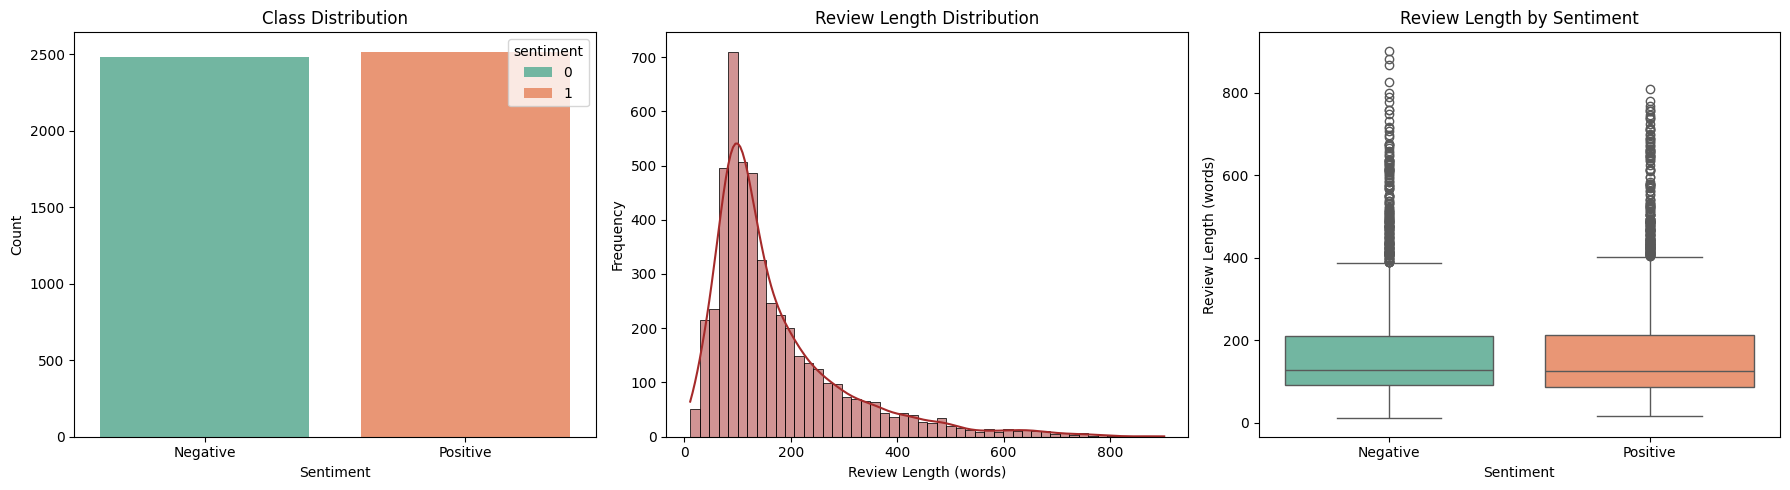

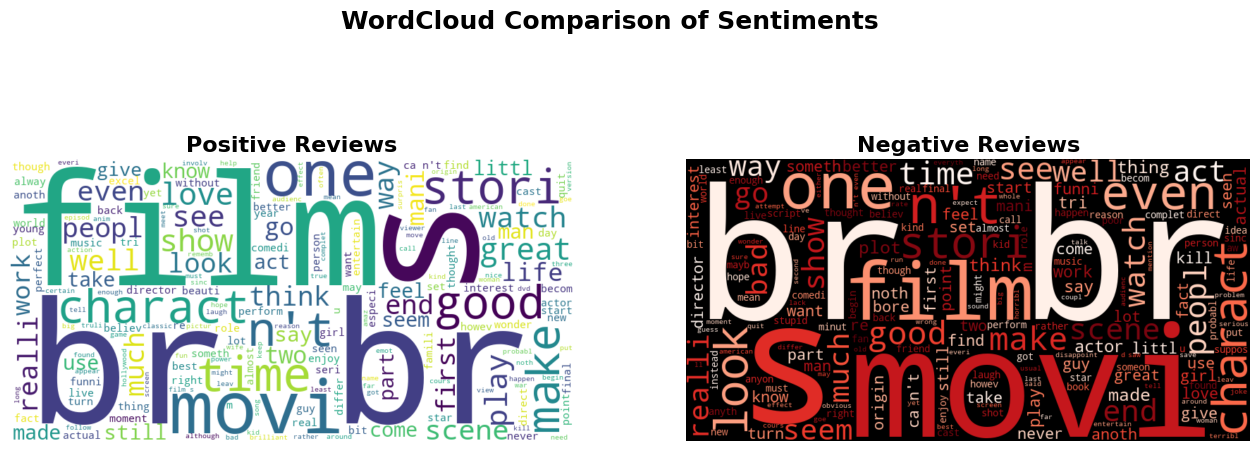

In [5]:
data['review_len'] = data['review'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Class balance
sns.countplot(x='sentiment', hue='sentiment', data=data, ax=axes[0], palette="Set2")
axes[0].set_title("Class Distribution")
axes[0].set_xlabel("Sentiment")
axes[0].set_ylabel("Count")
axes[0].set_xticks([0,1])
axes[0].set_xticklabels(["Negative", "Positive"])

# Review length distribution
sns.histplot(data['review_len'], bins=50, kde=True, ax=axes[1], color="brown")
axes[1].set_title("Review Length Distribution")
axes[1].set_xlabel("Review Length (words)")
axes[1].set_ylabel("Frequency")

# Boxplot by sentiment
sns.boxplot(x='sentiment', y='review_len', data=data, hue='sentiment', palette="Set2", legend=False, ax=axes[2])
axes[2].set_title("Review Length by Sentiment")
axes[2].set_xlabel("Sentiment")
axes[2].set_ylabel("Review Length (words)")
axes[2].set_xticks([0,1])
axes[2].set_xticklabels(["Negative", "Positive"])

plt.tight_layout()
plt.show()


# Wordclouds
pos_text = " ".join(data[data['sentiment']==1]['review'])
neg_text = " ".join(data[data['sentiment']==0]['review'])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(neg_text)

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Reviews", fontsize=16, weight="bold")

plt.subplot(1, 2, 2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Negative Reviews", fontsize=16, weight="bold")

plt.suptitle("WordCloud Comparison of Sentiments", fontsize=18, weight="bold")
plt.show()

## ⚙️ Feature Engineering (BoW vs TF-IDF)

In [6]:
# Bag of Words
cv = CountVectorizer(max_features=3000)
X_bow = cv.fit_transform(data['review']).toarray()

# TF-IDF
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(data['review']).toarray()

y = data['sentiment'].values

trainX_bow, testX_bow, trainY, testY = train_test_split(X_bow, y, test_size=0.2, random_state=42)
trainX_tfidf, testX_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## 🤖 Model Training & Comparison

In [6]:
models = {
    "Naive Bayes (BoW)": BernoulliNB(),
    "Naive Bayes (TF-IDF)": BernoulliNB(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

results = {}

# Train and evaluate
models["Naive Bayes (BoW)"].fit(trainX_bow, trainY)
y_pred_bow = models["Naive Bayes (BoW)"].predict(testX_bow)
results["Naive Bayes (BoW)"] = {
    "Accuracy": accuracy_score(testY, y_pred_bow),
    "Precision": precision_score(testY, y_pred_bow),
    "Recall": recall_score(testY, y_pred_bow),
    "F1": f1_score(testY, y_pred_bow)
}

models["Naive Bayes (TF-IDF)"].fit(trainX_tfidf, trainY)
y_pred_tfidf = models["Naive Bayes (TF-IDF)"].predict(testX_tfidf)
results["Naive Bayes (TF-IDF)"] = {
    "Accuracy": accuracy_score(testY, y_pred_tfidf),
    "Precision": precision_score(testY, y_pred_tfidf),
    "Recall": recall_score(testY, y_pred_tfidf),
    "F1": f1_score(testY, y_pred_tfidf)
}

for m in ["Logistic Regression", "SVM", "Random Forest"]:
    models[m].fit(trainX_tfidf, trainY)
    y_pred = models[m].predict(testX_tfidf)
    results[m] = {
        "Accuracy": accuracy_score(testY, y_pred),
        "Precision": precision_score(testY, y_pred),
        "Recall": recall_score(testY, y_pred),
        "F1": f1_score(testY, y_pred)
    }

Model Comparison (Accuracy, Precision, Recall, F1):



,Accuracy,Precision,Recall,F1
Naive Bayes (BoW),0.825,0.816,0.834,0.825
Naive Bayes (TF-IDF),0.825,0.816,0.834,0.825
Logistic Regression,0.859,0.832,0.895,0.862
SVM,0.852,0.825,0.889,0.856
Random Forest,0.829,0.837,0.812,0.824


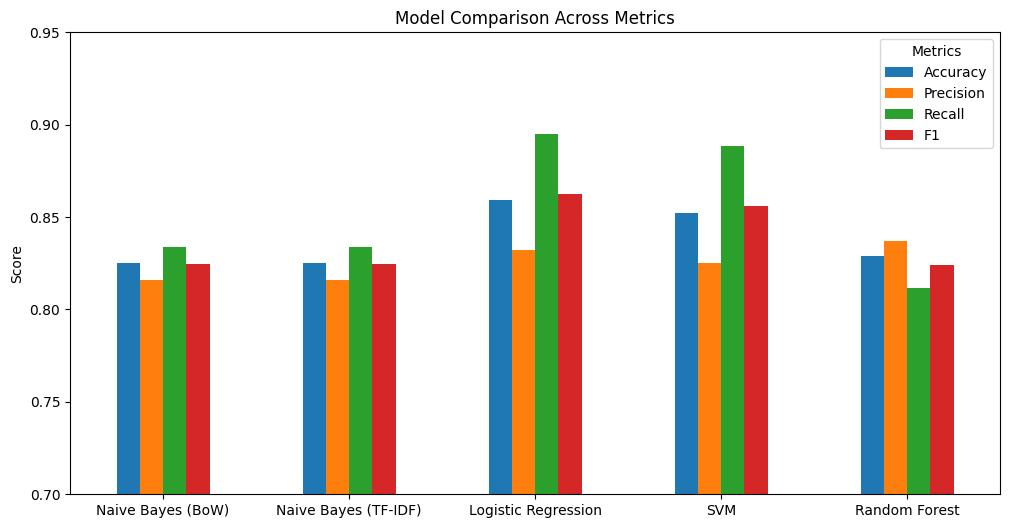

In [7]:
# ---- Tabular Comparison ----
metrics_df = pd.DataFrame(results).T  # results dict -> DataFrame
metrics_df = metrics_df[['Accuracy','Precision','Recall','F1']]  # order columns
print("Model Comparison (Accuracy, Precision, Recall, F1):\n")
display(
    metrics_df.style.format(precision=3).set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]},
         {'selector': 'td', 'props': [('text-align', 'center')]}]
    )
)
print("\n")

# ---- Bar Chart Visualization ----
ax = metrics_df.plot(kind="bar", figsize=(12,6))
plt.title("Model Comparison Across Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 0.95)
plt.xticks(rotation=0, ha="center")  # Rotate x-axis labels
plt.legend(title="Metrics")
plt.show()

## 📉 Confusion Matrix & ROC Curve

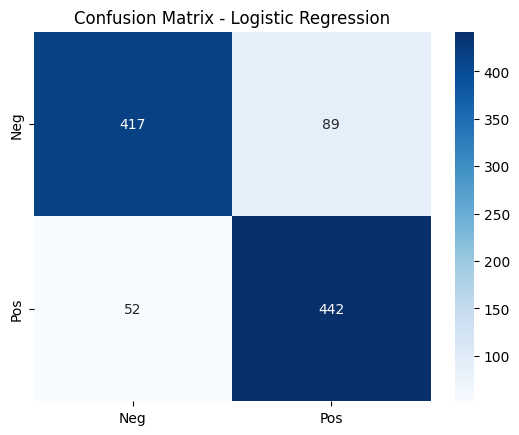

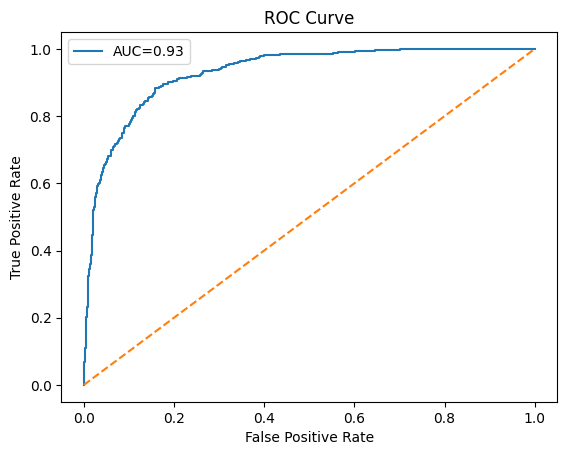

['tfidf.pkl']

In [8]:
from sklearn.metrics import roc_auc_score

best_model = models["Logistic Regression"]
y_pred = best_model.predict(testX_tfidf)
cm = confusion_matrix(testY, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos'])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# ROC Curve
y_prob = best_model.predict_proba(testX_tfidf)[:,1]
fpr, tpr, _ = roc_curve(testY, y_prob)
plt.plot(fpr, tpr, label="AUC="+str(round(auc(fpr,tpr),2)))
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the best model
joblib.dump(best_model, "best_model.pkl")
# Save the TF-IDF vectorizer (used for training Logistic Regression / SVM / RF)
joblib.dump(tfidf, "tfidf.pkl")

## ❌ Error Analysis

In [9]:
# Show some false positives & false negatives
preds = best_model.predict(testX_tfidf)

# Re-split but keep indices this time
train_idx, test_idx = train_test_split(data.index, test_size=0.2, random_state=42)
errors = pd.DataFrame({
    'review': data.loc[test_idx, 'review'].values,
    'actual': testY,
    'predicted': preds
})

false_pos = errors[(errors['actual']==0) & (errors['predicted']==1)]
false_neg = errors[(errors['actual']==1) & (errors['predicted']==0)]

# Count total
fp_count = false_pos.shape[0]
fn_count = false_neg.shape[0]

print(f"False Positives (total count: {fp_count}):")
print(false_pos[['review','actual','predicted']].head(3))  # show top 3 examples

print(f"\nFalse Negatives (total count: {fn_count}):")
print(false_neg[['review','actual','predicted']].head(3))  # show top 3 examples

False Positives (total count: 89):
                                               review  actual  predicted
26  appar viewer know noth histori europ , includ ...       0          1
36  could film deal illeg mexican immigr rob beate...       0          1
50  love music , , joyous oklahoma , poignant porg...       0          1

False Negatives (total count: 52):
                                               review  actual  predicted
20  good movi absolut unfair judg without take acc...       1          0
29  kid ideal tri chang thing around . boy forc be...       1          0
40  shame n't get screen credit , far best job fil...       1          0


## 🚀 Deployment Demo (Predict Sentiment for New Review)

In [7]:
import ipywidgets as widgets
from IPython.display import display
from lime.lime_text import LimeTextExplainer

# LIME setup
class_names = ["Negative", "Positive"]
explainer = LimeTextExplainer(class_names=class_names)

# Output widget
out = widgets.Output()

def predict_sentiment_with_highlight(review):
    # Clear previous output
    out.clear_output()
    
    # Preprocess review
    processed = stem_text(remove_stopwords(clean_text(review)))
    vec = tfidf.transform([processed]).toarray()

    # Predict
    pred = best_model.predict(vec)[0]
    prob = best_model.predict_proba(vec)[0][pred]
    label = "Positive" if pred == 1 else "Negative"

    # LIME explanation
    exp = explainer.explain_instance(
        review,
        lambda x: best_model.predict_proba(
            tfidf.transform([stem_text(remove_stopwords(clean_text(i))) for i in x])
        ),
        num_features=10
    )

    # Display prediction and explanation inside the Output widget
    with out:
        print(f"Prediction: {label} ({prob:.2f})\n")
        print("LIME Explanation:")
        for feature, weight in exp.as_list():
            print(f"{feature}: {weight:.4f}")

# --- Widget ---
text_input = widgets.Textarea(
    value="Avengers Endgame was absolutely phenomenal with emotional depth and epic action!",
    placeholder="Type your review here...",
    layout=widgets.Layout(width="100%", height="120px")
)

button = widgets.Button(
    description="Predict Sentiment",
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

def on_button_click(b):
    predict_sentiment_with_highlight(text_input.value)

button.on_click(on_button_click)
display(widgets.VBox([text_input, button, out]))
